# Import Libraries

In [2]:
!pip install -r requirements.txt -q

In [3]:
# Datahandling
import requests
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import numpy as np
import pandas as pd
import seaborn as sns

# Tweet Themes
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
import matplotlib.pyplot as plt
from bertopic import BERTopic
import plotly.express as px

# Network analysis
from typing import List, Optional
import json
import matplotlib.patches as mpatches
import networkx as nx
from community import community_louvain
import plotly.graph_objects as go
import random
from collections import defaultdict
import nbformat

# Model prediction
from setfit import SetFitModel, SetFitTrainer
from sklearn.metrics import classification_report
import tiktoken

# Gradio deployment
import gradio as gr


/Users/hedegaard/Documents/M3-TWITTERPROJECT/DDBMS-Submission/.conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data

In [4]:
# Data import: 
data = pd.read_csv('TwitterData_Joined.csv')

In [5]:
data.head()

,Twitter_User_Name,Twitter_Account,Twitter_User_Description,Tweet_id,Tweet_created_at,Tweet_text,Label,Word_Count,Url_Count,Retweet,...,Adverb_Count,Positive_Word_Ratio,Negative_Word_Ratio,Neutral_Word_Ratio,Following,Followers,Verified,Link,Location,Real_Location
0,Museum Bot,MuseumBot,I am a bot that tweets a random high-res Open ...,8.027580e+17,27-11-2016 06:15,Imperial Theatrical Coat for Court Lady https:...,0,8,2,0,...,0,0.000,0.0,1.000,0,7816,0,https://twitter.com/MuseumBot?s=20,NaN,-1.0
1,Museum Bot,MuseumBot,I am a bot that tweets a random high-res Open ...,8.746920e+17,13-06-2017 18:15,Half-length Figure of St Paul in an Oval. http...,0,10,2,0,...,0,0.000,0.0,1.000,0,7816,0,https://twitter.com/MuseumBot?s=20,NaN,-1.0
2,Museum Bot,MuseumBot,I am a bot that tweets a random high-res Open ...,6.983900e+17,13-02-2016 06:15,Great Exhibition Jurors&amp;#39; Medal https:/...,0,6,2,0,...,0,0.125,0.0,0.875,0,7816,0,https://twitter.com/MuseumBot?s=20,NaN,-1.0
3,Museum Bot,MuseumBot,I am a bot that tweets a random high-res Open ...,6.976650e+17,11-02-2016 06:15,Pair of candelabra https://t.co/KYopSWDSw2 htt...,0,5,2,0,...,0,0.000,0.0,1.000,0,7816,0,https://twitter.com/MuseumBot?s=20,NaN,-1.0
4,Museum Bot,MuseumBot,I am a bot that tweets a random high-res Open ...,6.217450e+17,16-07-2015 18:15,Banner (Nobori)\n http://t.co/yz34Xgo9a5 http:...,0,4,2,0,...,0,0.000,0.0,1.000,0,7816,0,https://twitter.com/MuseumBot?s=20,NaN,-1.0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279691 entries, 0 to 279690
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Twitter_User_Name         279691 non-null  object 
 1   Twitter_Account           279691 non-null  object 
 2   Twitter_User_Description  276027 non-null  object 
 3   Tweet_id                  279691 non-null  float64
 4   Tweet_created_at          279691 non-null  object 
 5   Tweet_text                279691 non-null  object 
 6   Label                     279691 non-null  int64  
 7   Word_Count                279691 non-null  int64  
 8   Url_Count                 279691 non-null  int64  
 9   Retweet                   279691 non-null  int64  
 10  Original_User             58391 non-null   object 
 11  Mentions_Count            279691 non-null  int64  
 12  Hashtags_Count            279691 non-null  int64  
 13  QuesMark_Count            279691 non-null  i

# Network Analysis

In [59]:
# data sampling? 20000
data = pd.read_csv('TwitterData_Joined.csv')
data = data.sample(n=20000, random_state=42)

## LLM-processing

In [54]:
# LLM Libs & Setup
from openai import OpenAI
import json
from pydantic import BaseModel, Field
from typing import List, Optional
import textwrap

In [55]:
#IF YOU'RE USING COLAB, YOU CAN ACCESS GOOGLE COLAB SECRETS, provided you've stored your Together API Key there -
# - If that's the case?: Eliminate the #'s below and delete the following line: TOGETHER_API_KEY = "PLACE YOUR API KEY HERE"

# from google.colab import userdata
# TOGETHER_API_KEY = userdata.get('TOGETHER_API_KEY')

TOGETHER_API_KEY = "5e0a972f095b5286c5c16a21521dd275cec67c79ffb8552d881d4620bee3254f" # - REMOVE TEXT AND INPUT YOUR TOGETHER API KEY HERE

client = OpenAI(
    base_url="https://api.together.xyz/v1",
    api_key=TOGETHER_API_KEY
)

model = "meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo"

In [56]:
SYSTEM_PROMPT = f"""
You are an advanced theme extraction assistant specialized in analyzing Twitter datasets. Your primary task is to identify overarching themes and sub-themes from a set of tweets.
Extraction Guidelines:
1. Thoroughly analyze the entire dataset
2. Identify the most prominent topics
3. Maintain objectivity and data-driven insights
4. Focus on substantive themes
5. Avoid superficial or random patterns
Output Requirements:
- Return results in a structured JSON format
- Include the following keys:
  * 'main_themes': List of primary themes
  * 'sub_themes': Detailed sub-themes
  * 'theme_confidence': Confidence level for each theme (0-100%)
  * 'sample_tweets': Example tweets supporting each theme

Key Principles:
- Be precise and contextually aware
- Provide data-driven thematic analysis
- Ensure comprehensive and nuanced interpretation
- Highlight meaningful patterns and trends
Linguistic Considerations:
- Consider tweet language and cultural context
- Account for hashtags, mentions, and trending topics
- Recognize potential sentiment and emotional undertones"

Output in JSON format only
{{
    "type": "object",
    "properties": {{
        "themes": {{
            "type": "array",
            "items": {{
                "type": "object",
                "properties": {{
                    "name": {{
                        "type": "string",
                        "description": "Primary theme identified"
                    }},
                    "confidence": {{
                        "type": "number", 
                        "minimum": 0,
                        "maximum": 100,
                        "description": "Confidence level of theme extraction"
                    }},
                    "sub_themes": {{
                        "type": "array",
                        "items": {{"type": "string"}},
                        "description": "Specific sub-categories within the theme"
                    }},
                    "keywords": {{
                        "type": "array", 
                        "items": {{"type": "string"}},
                        "description": "Key terms supporting the theme"
                    }},
                    "sentiment": {{
                        "type": "string",
                        "enum": ["positive", "negative", "neutral"],
                        "description": "Emotional tone of the theme"
                    }}
                }},
                "required": ["name", "confidence"]
            }}
        }},
        "metadata": {{
            "type": "object",
            "properties": {{
                "tweet_length": {{"type": "integer"}},
                "language": {{"type": "string"}},
                "contains_hashtags": {{"type": "boolean"}},
                "contains_mentions": {{"type": "boolean"}}
            }}
        }}
    }},
    "required": ["themes"]
}}
"""

In [29]:
json_schema = f"""
{{
    "type": "object",
    "properties": {{
        "themes": {{
            "type": "array",
            "items": {{
                "type": "object",
                "properties": {{
                    "name": {{
                        "type": "string",
                        "description": "Primary theme identified"
                    }},
                    "confidence": {{
                        "type": "number", 
                        "minimum": 0,
                        "maximum": 100,
                        "description": "Confidence level of theme extraction"
                    }},
                    "sub_themes": {{
                        "type": "array",
                        "items": {{"type": "string"}},
                        "description": "Specific sub-categories within the theme"
                    }},
                    "keywords": {{
                        "type": "array", 
                        "items": {{"type": "string"}},
                        "description": "Key terms supporting the theme"
                    }},
                    "sentiment": {{
                        "type": "string",
                        "enum": ["positive", "negative", "neutral"],
                        "description": "Emotional tone of the theme"
                    }}
                }},
                "required": ["name", "confidence"]
            }}
        }},
        "metadata": {{
            "type": "object",
            "properties": {{
                "tweet_length": {{"type": "integer"}},
                "language": {{"type": "string"}},
                "contains_hashtags": {{"type": "boolean"}},
                "contains_mentions": {{"type": "boolean"}}
            }}
        }}
    }},
    "required": ["themes"]
}}
"""

In [50]:
import tiktoken
import pandas as pd
import json
from openai import OpenAI
import concurrent.futures
def process_large_batch_tweets(tweets, batch_size=100):
    """
    Proces store batches af tweets (op til 100) i et enkelt API-kald
    """
    try:
        # Forbered beskeder til batch-processing
        messages = [
            {'role': 'system', 'content': SYSTEM_PROMPT},
            {'role': 'user', 'content': json.dumps(tweets)}
        ]
        
        # API-kald med hele batchen
        response = client.chat.completions.create(
            model=model,
            messages=messages,
            temperature=0.7,
            response_format={"type": "json_object"},
            max_tokens=64000  # Sikrer maks token-begrænsning
        )
        
        # Parse svaret
        processed_response = response.choices[0].message.content
        
        return {
            'batch_size': len(tweets),
            'processed_response': processed_response
        }
    
    except Exception as e:
        return {
            'batch_size': len(tweets),
            'error': str(e)
        }
def process_all_tweets_in_large_batches(data, batch_size=100):
    """
    Batch-proces alle tweets i store batches
    """
    processed_results = []
    
    # Del datasættet i store batches
    for i in range(0, len(data), batch_size):
        batch = data.iloc[i:i+batch_size]
        tweets = batch['Tweet_text'].tolist()
        
        # Proces batch
        result = process_large_batch_tweets(tweets, batch_size)
        processed_results.append(result)
        
        # Løbende gemning
        if len(processed_results) % 10 == 0:
            temp_df = pd.DataFrame(processed_results)
            temp_df.to_csv('midlertidige_resultater.csv', index=False)
        
        print(f"Behandlet batch {i//batch_size + 1}")
        
        # Lille pause mellem batches
        time.sleep(1)
    
    # Konverter til DataFrame
    result_df = pd.DataFrame(processed_results)
    return result_df
# Brug funktionen
processed_tweets = process_all_tweets_in_large_batches(
    data, 
    batch_size=200  # Op til 200 tweets pr. batch
)
processed_tweets.to_csv('endelige_resultater.csv', index=False)

Behandlet batch 1
Behandlet batch 2
Behandlet batch 3


KeyboardInterrupt: 

## BATCH PROCESSING

In [62]:
import tiktoken
import pandas as pd
import json
from openai import OpenAI
import concurrent.futures
import time
import queue
import threading
def rate_limited_executor(max_calls_per_minute=60):
    """
    Rate-limited executor til API-kald
    """
    # Opret en kø til at styre API-kald
    call_queue = queue.Queue()
    
    def worker():
        while True:
            # Hent næste kald fra køen
            func, args, kwargs, result_queue = call_queue.get()
            
            try:
                # Udfør API-kaldet
                result = func(*args, **kwargs)
                result_queue.put(result)
            except Exception as e:
                result_queue.put(e)
            
            # Markér opgave som færdig
            call_queue.task_done()
            
            # Begræns kald til maks 60 pr. minut
            time.sleep(1)  # 1 sekund mellem kald
    
    # Start worker tråde
    for _ in range(max_calls_per_minute):
        threading.Thread(target=worker, daemon=True).start()
    
    def submit(func, *args, **kwargs):
        # Opret resultat-kø
        result_queue = queue.Queue()
        
        # Indsæt kald i køen
        call_queue.put((func, args, kwargs, result_queue))
        
        # Vent på resultat
        result = result_queue.get()
        
        # Håndter eventuelle fejl
        if isinstance(result, Exception):
            raise result
        
        return result
    
    return submit
def process_large_batch_tweets(tweets, batch_size=100, executor=None):
    """
    Proces store batches af tweets med rate limiting
    """
    try:
        # Forbered beskeder til batch-processing
        messages = [
            {'role': 'system', 'content': SYSTEM_PROMPT},
            {'role': 'user', 'content': json.dumps(tweets)}
        ]
        
        # Brug executor til API-kald
        if executor:
            response = executor(
                client.chat.completions.create,
                model=model,
                messages=messages,
                temperature=0.7,
                response_format={"type": "json_object"},
                max_tokens=60000
            )
        else:
            # Standard API-kald uden rate limiting
            response = client.chat.completions.create(
                model=model,
                messages=messages,
                temperature=0.7,
                response_format={"type": "json_object"},
                max_tokens=60000
            )
        
        # Parse svaret
        processed_response = response.choices[0].message.content
        
        return {
            'batch_size': len(tweets),
            'processed_response': processed_response
        }
    
    except Exception as e:
        return {
            'batch_size': len(tweets),
            'error': str(e)
        }
def process_all_tweets_in_parallel(data, batch_size=100, max_workers=6):
    """
    Parallel processering af tweets med rate limiting
    """
    # Opret rate-limited executor
    executor = rate_limited_executor(max_calls_per_minute=60)
    
    processed_results = []
    
    # Brug ThreadPoolExecutor til parallel processering
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as pool:
        # Forbered futures
        futures = []
        for i in range(0, len(data), batch_size):
            batch = data.iloc[i:i+batch_size]
            tweets = batch['Tweet_text'].tolist()
            
            # Send batch til parallel processering
            future = pool.submit(
                process_large_batch_tweets, 
                tweets, 
                batch_size, 
                executor
            )
            futures.append(future)
        
        # Indsaml resultater løbende
        for future in concurrent.futures.as_completed(futures):
            result = future.result()
            processed_results.append(result)
            
            # Løbende gemning
            if len(processed_results) % 10 == 0:
                temp_df = pd.DataFrame(processed_results)
                temp_df.to_csv('midlertidige_resultater.csv', index=False)
                print(f"Gemt {len(processed_results)} resultater")
    
    # Konverter til DataFrame
    result_df = pd.DataFrame(processed_results)
    return result_df
# Brug funktionen
processed_tweets = process_all_tweets_in_parallel(
    data, 
    batch_size=100,    # Batch størrelse
    max_workers=6      # Antal parallelle tråde
)
processed_tweets.to_csv('endelige_resultater.csv', index=False)

Gemt 10 resultater


KeyboardInterrupt: 

In [34]:
import tiktoken
import json

# Konfiguration
MODEL_NAME = "meta-llama/Llama-3.2-3B-Instruct-Turbo"
MAX_TOKENS_PER_CHUNK = 6400
MAX_TOTAL_TOKENS = 64000
SYSTEM_PROMPT = "Extract key insights and themes from the following tweet."

# Initialiser encoding baseret på model
def get_encoding_for_model(model_name):
    try:
        if "llama" in model_name.lower():
            return tiktoken.get_encoding("cl100k_base")
        return tiktoken.encoding_for_model(model_name)
    except Exception:
        return tiktoken.get_encoding("cl100k_base")

# Funktioner til token-håndtering
def count_tokens(text, encoding):
    return len(encoding.encode(str(text)))

def split_text_into_chunks(text, max_tokens, encoding):
    tokens = encoding.encode(str(text))
    return [encoding.decode(tokens[i:i + max_tokens]) for i in range(0, len(tokens), max_tokens)]

# Forbered batches
def prepare_batches(dataframe, text_column, model_name, max_total_tokens, max_tokens_per_chunk):
    encoding = get_encoding_for_model(model_name)
    batches, current_batch, current_tokens = [], [], 0
    batch_number = 1

    for idx, text in enumerate(dataframe[text_column].dropna().astype(str)):
        if not text.strip():
            continue
        
        chunks = split_text_into_chunks(text, max_tokens_per_chunk, encoding)
        
        for chunk_idx, chunk in enumerate(chunks):
            system_tokens = count_tokens(SYSTEM_PROMPT, encoding)
            chunk_tokens = count_tokens(chunk, encoding)
            tokens_per_request = system_tokens + chunk_tokens + 50  # Buffer for svar
            
            if tokens_per_request > max_total_tokens:
                print(f"Skipping chunk {idx + 1}-{chunk_idx + 1}: Exceeds token limit.")
                continue

            if current_tokens + tokens_per_request > max_total_tokens:
                print(f"Batch {batch_number} token limit reached.")
                batches.append(current_batch)
                current_batch, current_tokens = [], 0
                batch_number += 1
            
            request = {
                "custom_id": f"request-{idx + 1}-chunk-{chunk_idx + 1}",
                "method": "POST",
                "url": "/v1/chat/completions",
                "body": {
                    "model": model_name,
                    "messages": [
                        {"role": "system", "content": SYSTEM_PROMPT},
                        {"role": "user", "content": chunk}
                    ],
                    "max_tokens": max_tokens_per_chunk
                }
            }
            current_batch.append(request)
            current_tokens += tokens_per_request

    if current_batch:
        batches.append(current_batch)
    return batches

# Brug funktion til batch-forberedelse
try:
    batches = prepare_batches(
        dataframe=data,
        text_column="Tweet_text",
        model_name=MODEL_NAME,
        max_total_tokens=MAX_TOTAL_TOKENS,
        max_tokens_per_chunk=MAX_TOKENS_PER_CHUNK,
    )
    print(f"Prepared {len(batches)} batches with {sum(len(batch) for batch in batches)} requests.")
except Exception as e:
    print(f"Error during batch preparation: {e}")


Batch 1 token limit reached.
Batch 2 token limit reached.
Batch 3 token limit reached.
Prepared 4 batches with 2000 requests.


In [35]:
import json
import time
import pandas as pd

# Funktion til at rense ugyldige escape-sekvenser
def clean_invalid_escapes(text):
    """
    Rens tekst for ugyldige escape-sekvenser.
    """
    try:
        return text.encode('utf-8').decode('unicode_escape')
    except (UnicodeDecodeError, ValueError):
        # Fallback: Erstat \ med dobbelt \\
        return text.replace("\\", "\\\\")

# Funktion til at behandle én batch-request med json_schema og SYSTEM_PROMPT
def process_tweet_with_together(json_schema, system_prompt, model):
    """
    Processér en enkelt prompt med LLM og håndter JSON-output.
    """
    try:
        response = client.chat.completions.create(
            model=model,
            messages=[
                {'role': 'system', 'content': system_prompt},
                {'role': 'user', 'content': json_schema}
            ],
            temperature=0.7
        )
        
        # Rens og parse respons
        response_text = clean_invalid_escapes(response.choices[0].message.content.strip())
        
        try:
            return json.loads(response_text)
        except json.JSONDecodeError:
            # Fallback til at finde JSON-tekst
            json_start = response_text.find('{')
            json_end = response_text.rfind('}') + 1
            if json_start >= 0 and json_end > json_start:
                json_str = response_text[json_start:json_end]
                return json.loads(json_str)
            else:
                print(f"Kunne ikke parse JSON:\n{response_text}")
                raise
        
    except Exception as e:
        print(f"Fejl ved API-kald: {e}")
        return None

# Funktion til at behandle batches
def process_batches(batches, system_prompt, model):
    """
    Behandle alle batches og samle resultater.
    """
    all_results = []

    for batch_idx, batch_requests in enumerate(batches, 1):
        batch_results = []
        print(f"Behandler batch {batch_idx} - Total requests: {len(batch_requests)}")
        
        for request in batch_requests:
            try:
                json_schema = request['body']['messages'][1]['content']
                
                # Processér prompt med LLM
                result = process_tweet_with_together(json_schema, system_prompt, model)
                
                if result is not None:
                    # Tilføj custom_id for tracking
                    result['custom_id'] = request['custom_id']
                    batch_results.append(result)
            except Exception as req_error:
                print(f"Fejl i request {request.get('custom_id', 'Ukendt')}: {req_error}")
        
        # Saml batch-resultater
        all_results.extend(batch_results)
        print(f"Færdig med batch {batch_idx}. Resultater: {len(batch_results)}")
        
        # Vent for at undgå rate limits
        time.sleep(0)
    
    return all_results

# Hovedfunktion til at køre batch-processering
try:
    # Indtast SYSTEM_PROMPT og modelnavn her
    SYSTEM_PROMPT = "Extract key insights and themes from the provided data."
    MODEL_NAME = "meta-llama/Llama-3.2-3B-Instruct-Turbo"

    final_results = process_batches(batches, SYSTEM_PROMPT, MODEL_NAME)
    
    # Konverter resultater til DataFrame for yderligere analyse
    results_df = pd.DataFrame(final_results)
    print("Behandling færdig! Resultater er konverteret til DataFrame.")
except Exception as e:
    print(f"Samlet fejl ved batch-behandling: {e}")


Behandler batch 1 - Total requests: 668
Kunne ikke parse JSON:
Unfortunately, I don't see any data provided. You haven't shared any information to extract key insights and themes from. Could you please provide the data or context you'd like me to work with?
Fejl ved API-kald: Expecting value: line 1 column 1 (char 0)
Kunne ikke parse JSON:
Key Insights and Themes:

1. **Misrepresentation of Islam**: The tweet's phrase "religion of peace" is a common misconception about Islam. While Islam is a religion that emphasizes peace, the tweet's tone and hashtag #IslamicTeachings imply that the tweet may be perpetuating a negative or inaccurate stereotype about Islam.

2. **Social Media Politics**: The tweet appears to be a response to criticism or misinformation about Islam, trying to reclaim and redefine the narrative around the religion.

3. **Tone and Language**: The use of "We r" and "https://t.co/mo3iFLyEDv" suggests a casual, informal tone, which may come across as insensitive or dismissi

KeyboardInterrupt: 

## UMAP

Batches: 100%|██████████| 63/63 [00:06<00:00,  9.25it/s]
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


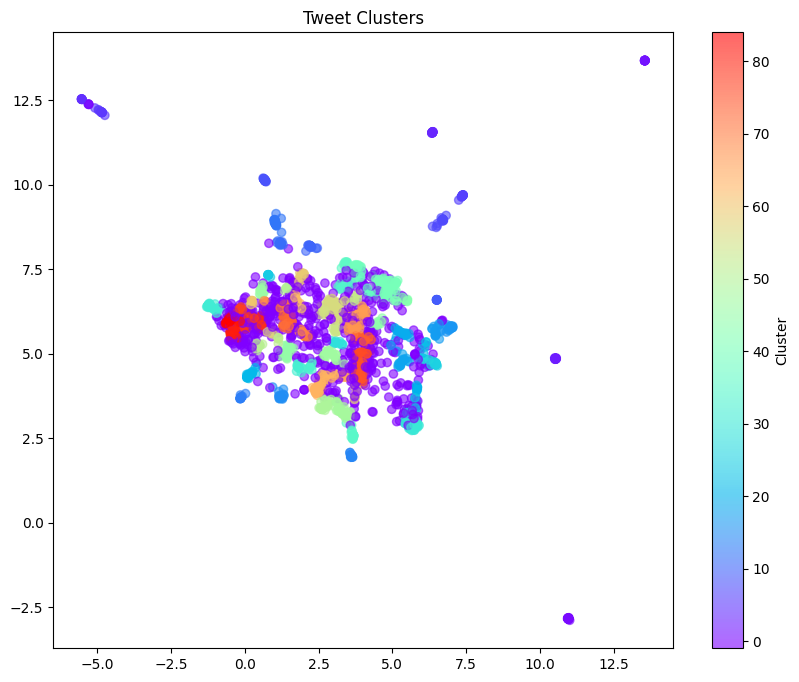


Cluster 0 examples:
169818    flr(sgn(at2(min(t,y)+y+2.55,flr(flr(2.43)))))+...
169387    pow(max(cos(sqt(4.45)),sqt(min(8.07,y))),exp(f...
171327    abs(flr(sqt(3.32*y))-sig(sqt(x))%sqt(x+4.60))+...
Name: Tweet_text, dtype: object

Cluster 1 examples:
247146    @PrPrasoon This Republic Day, remember, you do...
248117    @djfaran This Republic Day, remember, you do n...
248398    @MotinuddinS This Republic Day, remember, you ...
Name: Tweet_text, dtype: object

Cluster 2 examples:
219240         GET BACK TO WORK July 14, 2016 at 11:00AM
221184        GET BACK TO WORK April 23, 2016 at 11:00AM
219728    GET BACK TO WORK September 19, 2017 at 04:00PM
Name: Tweet_text, dtype: object

Cluster 3 examples:
228120    RT @TrepLaw: WIBW Digital Marketing Executive ...
228540    @MarcusBMavakala Thanks for taking a look at S...
230163    @SanJoseCP Thanks for taking a look at Small B...
Name: Tweet_text, dtype: object

Cluster 4 examples:
136566    BONG BONG BONG BONG BONG BONG BONG BONG BONG B

In [7]:
# 2. Transformer tekst til embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')  # Hurtig og effektiv model
embeddings = model.encode(data['Tweet_text'].tolist(), show_progress_bar=True)

# 3. Reducer dimensioner med UMAP
umap_embeddings = umap.UMAP(
    n_neighbors=15,
    n_components=2,
    min_dist=0.0,
    metric='cosine'
).fit_transform(embeddings)

# 4. Cluster med HDBSCAN
clusters = hdbscan.HDBSCAN(
    min_cluster_size=5,
    min_samples=5,
    metric='euclidean'
).fit_predict(umap_embeddings)

# 5. Tilføj resultater til dataframe
data['Cluster'] = clusters

# 6. Visualiser
plt.figure(figsize=(10, 8))
plt.scatter(
    umap_embeddings[:, 0],
    umap_embeddings[:, 1],
    c=clusters,
    cmap='rainbow',
    alpha=0.6
)
plt.title('Tweet Clusters')
plt.colorbar(label='Cluster')
plt.show()

# 7. Vis eksempler fra hver cluster
for cluster in set(clusters):
    if cluster != -1:  # Skip noise cluster
        print(f"\nCluster {cluster} examples:")
        print(data[data['Cluster'] == cluster]['Tweet_text'].head(3))

In [9]:
# sample data for bertopic
sample_size = min(2000, len(data))
sampled_data = data.sample(n=sample_size, random_state=42)

# transform text to embeddings
model = SentenceTransformer('all-mpnet-base-v2')
embeddings = model.encode(data['Tweet_text'].tolist(), show_progress_bar=True)

# reduce dimensions and cluster
umap_embeddings = umap.UMAP(
    n_neighbors=15,
    n_components=2,
    min_dist=0.1,
    metric='cosine',
    random_state=42
).fit_transform(embeddings)

# HDSBScan for clustering:
clusters = hdbscan.HDBSCAN(
    min_cluster_size=20,
    min_samples=10,
    metric='euclidean'
).fit_predict(umap_embeddings)

# use bertopic to name clusters
topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
topics, _ = topic_model.fit_transform(sampled_data['Tweet_text'].tolist())

# create dataframe for plotting
plot_df = pd.DataFrame({
    'UMAP1': umap_embeddings[:, 0],
    'UMAP2': umap_embeddings[:, 1],
    'Cluster': clusters,
    'Tweet_text': data['Tweet_text']
})

# add cluster names
cluster_names = {}
for cluster in set(clusters):
    if cluster != -1:
        cluster_tweets = plot_df[plot_df['Cluster'] == cluster]['Tweet_text']
        cluster_topic = topic_model.get_topic(topic_model.transform(cluster_tweets.sample(n=min(1000, len(cluster_tweets))).tolist())[0][0])
        cluster_names[cluster] = ', '.join([word for word, _ in cluster_topic[:3]])
    else:
        cluster_names[cluster] = 'noise'

plot_df['Cluster_Name'] = plot_df['Cluster'].map(cluster_names)

# visualize
fig = px.scatter(
    plot_df,
    x='UMAP1',
    y='UMAP2',
    color='Cluster_Name',
    hover_data=['Tweet_text'],
    title='Tweet_text Clusters'
)

# add simple interactivity
fig.update_layout(
    updatemenus=[{
        'buttons': [
            {'label': 'All Clusters', 'method': 'update', 'args': [{'visible': True}]},
            *[{'label': name, 'method': 'update', 'args': [{'visible': [name == n for n in plot_df['Cluster_Name']]}]} 
              for name in plot_df['Cluster_Name'].unique() if name != 'noise']
        ],
        'direction': 'down',
        'showactive': True,
    }]
)

# show figure
fig.show()

# save results
plot_df.to_csv('tweet_analysis.csv', index=False)
fig.write_html("interactive_tweet_clusters.html")

print("analysis completed. results saved and visualization opened in your browser.")

Batches: 100%|██████████| 63/63 [02:48<00:00,  2.67s/it]
2024-11-18 21:49:11,100 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 63/63 [02:11<00:00,  2.09s/it]
2024-11-18 21:51:42,455 - BERTopic - Embedding - Completed ✓
2024-11-18 21:51:42,468 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-11-18 21:51:45,584 - BERTopic - Dimensionality - Completed ✓
2024-11-18 21:51:45,658 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-11-18 21:51:46,488 - BERTopic - Cluster - Completed ✓
2024-11-18 21:51:47,192 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-11-18 21:51:48,444 - BERTopic - Representation - Completed ✓
Batches: 100%|██████████| 1/1 [00:13<00:00, 13.72s/it]
2024-11-18 21:52:02,533 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2024-11-18 21:52:04,562 - BERTopic - Dimensionality - Completed ✓
2024-11-18 21:52:04,568 

analysis completed. results saved and visualization opened in your browser.


In [10]:
# Count the clusters
theme_counts = plot_df['Cluster_Name'].value_counts()

# convert to DataFrame
theme_analysis = pd.DataFrame({
    'Theme': theme_counts.index,
    'Count': theme_counts.values,
    'Percent': (theme_counts.values / len(plot_df) * 100).round(2)
})

# Set theme as index
theme_analysis.set_index('Theme', inplace=True)

# sort by Count in descending order
theme_analysis = theme_analysis.sort_values('Count', ascending=False)

print("Theme analysis:")
print("===============")
print(theme_analysis)

# save to CSV if desired
theme_analysis.to_csv('theme_analysis.csv')

Theme analysis:
                                                    Count  Percent
Theme                                                             
the, to, of                                          1719    85.95
noise                                                  56     2.80
eu, te, xc3xa9                                         30     1.50
winelover, wine, thewinehub                            29     1.45
bong, ,                                                29     1.45
neural, network, absflrsqt332ysigsqtxsqtx460abs...     27     1.35
netflix, available, instant                            24     1.20
planet, discovered, have                               23     1.15
boykhat, champainful, walconverse                      22     1.10
work, back, get                                        21     1.05
allsorts, liquorice, licorice                          20     1.00


## Data Sampling

In [50]:
# data sampling? 5000
data = pd.read_csv('TwitterData_Joined.csv')
data = data.sample(n=10000, random_state=42)

## Hashtag extraction

In [51]:
import re
def extract_hashtags(text):
    return ' '.join(re.findall(r'#\w+', str(text))).replace('#', '')
# Alternativt:
def extract_hashtags_alt(text):
    return ' '.join(tag.strip('#') for tag in str(text).split() if tag.startswith('#'))
# Tilføj kolonnen
data['hashtags'] = data['Tweet_text'].apply(extract_hashtags)

## Hashtag Network Analysis

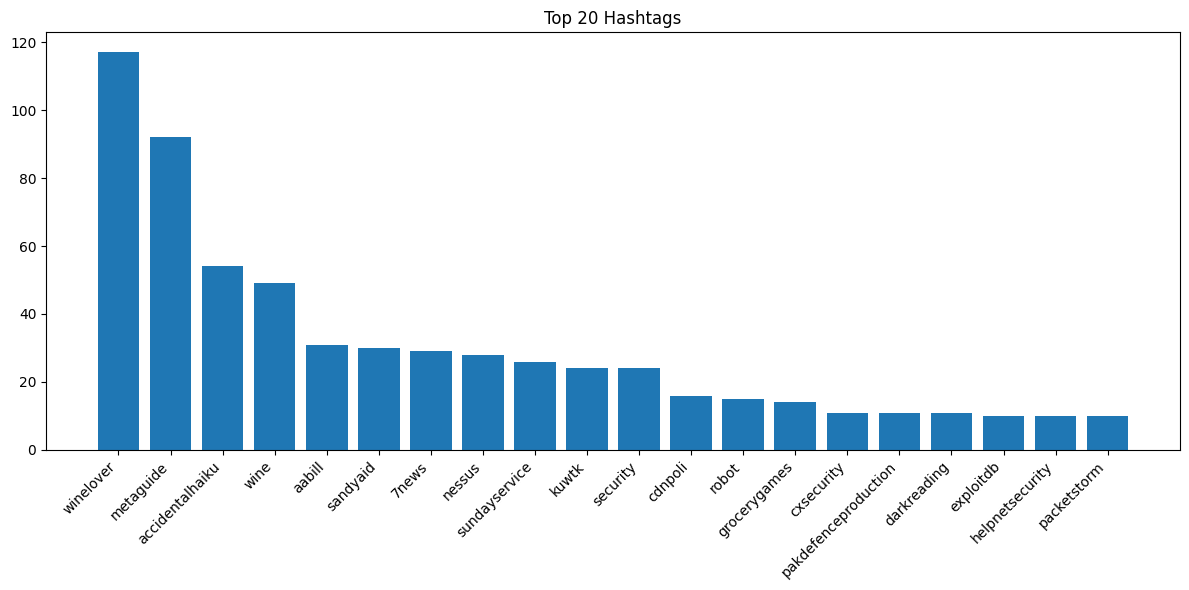

In [52]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import networkx as nx

# Antager at 'data' er jeres DataFrame og 'Hashtags' kolonnen allerede eksisterer

# Saml alle hashtags
# Først, lad os sikre os, at hashtags er i en liste-format
def ensure_list(hashtags):
    if isinstance(hashtags, list):
        return hashtags
    elif isinstance(hashtags, str):
        return hashtags.split(' ') 
    else:
        return []

data['hashtag_list'] = data['hashtags'].apply(ensure_list)

all_hashtags = [hashtag.lower().strip() for tweet in data['hashtag_list'] for hashtag in tweet if hashtag]

# Tæl frekvenser
hashtag_counts = Counter(all_hashtags)

# Filtrer og sortér
min_count = 10  # Juster efter behov
top_hashtags = {k: v for k, v in hashtag_counts.items() if v >= min_count}
sorted_hashtags = sorted(top_hashtags.items(), key=lambda x: x[1], reverse=True)

# Visualiser top hashtags
plt.figure(figsize=(12, 6))
plt.bar(*zip(*sorted_hashtags[:20]))
plt.xticks(rotation=45, ha='right')
plt.title('Top 20 Hashtags')
plt.tight_layout()
plt.show()

In [53]:
import pandas as pd
import networkx as nx
from collections import Counter
import itertools
import plotly.graph_objects as go

# Indlæs data - hvis data allerede er indlæst, så brug det eksisterende df (data)
# data = pd.read_csv('filtered_data.csv')  # Hvis du skal læse fra fil
# Antager, at data allerede er defineret i din session.

# Opret en graf
G = nx.Graph()

# Initialize dictionary to keep track of hashtag pairs (edges)
hashtag_pairs = Counter()

# Gennemgå tweets og find hashtags
for tweet in data['hashtags'].dropna():  # Fjern NaN-værdier
    hashtags = tweet.split()  # Del på mellemrum
    if len(hashtags) > 1:
        # Find alle par af hashtags i samme tweet og opdater tælleren
        for pair in itertools.combinations(hashtags, 2):
            hashtag_pairs[pair] += 1

# Tilføj noder og kanter til grafen
for pair, weight in hashtag_pairs.items():
    G.add_edge(pair[0], pair[1], weight=weight)

# Beregn centralitetsmål
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)

# Visualisering
node_size = [20 + 100 * degree_centrality[node] for node in G.nodes]
pos = nx.spring_layout(G, k=1, iterations=50, seed=42)

# Edge positions og node positions
edge_x, edge_y = [], []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]

node_x, node_y, node_text = [], [], []
for node in G.nodes:
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_text.append(
        f"Hashtag: {node}<br>"
        f"Degree Centrality: {degree_centrality[node]:.3f}<br>"
        f"Betweenness Centrality: {betweenness_centrality[node]:.3f}<br>"
        f"Eigenvector Centrality: {eigenvector_centrality[node]:.3f}"  # Tilføjet Eigenvector Centrality
    )

# Opret Plotly-figur
fig = go.Figure()

# Tilføj kanter
fig.add_trace(go.Scatter(
    x=edge_x,
    y=edge_y,
    mode='lines',
    line=dict(width=0.8, color='rgba(169,169,169,0.5)'),
    hoverinfo='none'
))

# Tilføj noder
fig.add_trace(go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers+text',
    text=[node for node in G.nodes],
    textposition="top center",
    hovertext=node_text,  # Nu vises Eigenvector Centrality i hovertext
    hoverinfo='text',
    marker=dict(
        size=node_size,
        color=[degree_centrality[node] for node in G.nodes],
        colorscale='Viridis',
        line=dict(width=1, color='white'),
        showscale=True,
        colorbar=dict(title="Centrality")
    )
))

# Layout og interaktivitet
fig.update_layout(
    title="Hashtag Network",
    width=1200,
    height=1000,
    showlegend=False,
    hovermode='closest',
    plot_bgcolor='rgb(250,250,250)',
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
)

fig.show()


# Machine Learning